## First step on deep learning using tensorflow
 在第九节课上，给大家介绍了深度学习的知识。这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作全连接网络
 在本次作业中，将会使用经典数据集mnist的升级版， notMnist构建神经网络进行图像分类
 本次作业，需要完成1、2、3个联系，能够掌握：    
      1.数据预处理知识  
      2.深度学习程序的构建方式  
      3.训练集、测试集、验证集  
      4.神经网络的基础知识  
      5.图计算网络  
      6.正则化

 ## Assignment 1
 The objective of this assignment is to learn about simple data curation practices , and familiarize you with some of the data we'll be reusing later
 this notebook uses the notMnist datasets to be used in pyhon experiments. This dataset is designed to look like the classic MNIST dataset,  while looking more like real data: it's a hard task, and the data is a lot less 'clean' than MNIST.

In [1]:
# there are all modules we'll be using later. Make sure you can import them before proceeding further
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


In [2]:
# Configure the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine.The data consists of characters rendered in a variety of fonts on a 28*28 image.
The lables are limited to "A" throuth "J"(10 classes). The training set has 500k and testset 19000 lebeled examples.Given these sizes, it should be possible to train models quickly on any machine.

In [10]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'D:\\Document\\PythonWork\\NLP' # change me to store elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to progress of a download. This is mostly intended for users 
    with slow internet connections. Report every 5% change in download progress.
    """
    global last_percent_reported 
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        last_percent_reported = percent
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size
    """
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempt to download :', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook = download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify' + dest_filename + ' . Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz',247336696)
test_filename = maybe_download('notMINST_small.tar.gz', 8458043)

Attempt to download : notMNIST_large.tar.gz


URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>

Extract the dataset from the compressed tar.gz file. this will give you a set of directories, labeled A through J

In [11]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force = False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print('%s already present = SKipping extraction of %s. ' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders=[os.path.join(root,d) for d in sorted(os.listdir(root)) 
                  if os.path.isdir(os.path.join(root,d))]
    if len(data_folders)!= num_classes:
        raise Exception('Excepted %d folders, one per class. Found %d instead.' %(num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

In [35]:
train_folders = maybe_extract("D:\\Document\\PythonWork\\NLP\\notMNIST_large.tar.gzip")
test_folders = maybe_extract("D:\\Document\\PythonWork\\NLP\\notMNIST_small.tar.gzip")

D:\Document\PythonWork\NLP\notMNIST_large already present = SKipping extraction of D:\Document\PythonWork\NLP\notMNIST_large.tar.gzip. 
['D:\\Document\\PythonWork\\NLP\\notMNIST_large\\A', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\B', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\C', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\D', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\E', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\F', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\G', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\H', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\I', 'D:\\Document\\PythonWork\\NLP\\notMNIST_large\\J']
D:\Document\PythonWork\NLP\notMNIST_small already present = SKipping extraction of D:\Document\PythonWork\NLP\notMNIST_small.tar.gzip. 
['D:\\Document\\PythonWork\\NLP\\notMNIST_small\\A', 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\B', 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\C', 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\D'

# Problem 1 
Let's take a peek at the data to make sure it looks sensible. Every examlar should be a image of character A through J rendered in different fonts. Display a sample of image that we just downloaded. Hint: you can use the package: IPython.display

Now let's load the data in a more managable format. Since, depending on youre computer memory, you might not be able to fit all in a memory, we'll load each class into a seperate dataset, store them on disk and curate them independently. later we'll merge them into a single dataset of managable size.  

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point value, normalized to have appoximately zero mean and standard deviation ~0.5 to make training easier down the road.
A few image may not be readable. Let's skip them.

In [36]:
image_size = 28 # Pixel width and height
pixel_depth = 255.0 # Number of levels per pixel

def load_letter(folder, min_num_images):
    """Load the data for a single letter label    """
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape = (len(image_files),image_size,image_size),dtype = np.float32)
    
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float)-pixel_depth/2)/pixel_depth
            if image_data.shape != (image_size,image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1 
        except (IOError, ValueError) as e:
            print('Could not read: ', image_file, ':', e, '- it\'s ok, skipping.')
    dataset = dataset[0:num_images, :,:]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:',np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force = False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # you may override by setting force = True
            print('%s already present = Skipping pickling.' % set_filename)
        else:
            print('Pickling %s' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
        return dataset_names
    
train_datasets = maybe_pickle(train_folders, 1800)
#test_datasets = maybe_pickle(test_folders, 45000)

Pickling D:\Document\PythonWork\NLP\notMNIST_large\A.pickle
D:\Document\PythonWork\NLP\notMNIST_large\A
Could not read:  D:\Document\PythonWork\NLP\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read:  D:\Document\PythonWork\NLP\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read:  D:\Document\PythonWork\NLP\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825024
Standard deviation: 0.44312063
Unable to save data to D:\Document\PythonWork\NLP\notMNIST_large\A.pickle : name 'pick' is not defined


In [38]:
# image_size = 28  # Pixel width and height.
# pixel_depth = 255.0  # Number of levels per pixel.


# def load_letter(folder, min_num_images):
#     """Load the data for a single letter label."""
#     image_files = os.listdir(folder)
#     dataset = np.ndarray(shape=(len(image_files), image_size, image_size),dtype=np.float32)
#     print(folder)
#     num_images = 0
#     for image in image_files:
#         image_file = os.path.join(folder, image)
#         try:
#             image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
#         if image_data.shape != (image_size, image_size):
#             raise Exception('Unexpected image shape: %s' % str(image_data.shape))
#         dataset[num_images, :, :] = image_data
#         num_images = num_images + 1
#     except (IOError, ValueError) as e:
#         print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
#     dataset = dataset[0:num_images, :, :]
#     if num_images < min_num_images:
#         raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
#     print('Full dataset tensor:', dataset.shape)
#     print('Mean:', np.mean(dataset))
#     print('Standard deviation:', np.std(dataset))
#     return dataset


def load_letter(folder, min_num_images):
    """Load the data for a single letter label    """
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape = (len(image_files),image_size,image_size),dtype = np.float32)
    
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float)-pixel_depth/2)/pixel_depth
            if image_data.shape != (image_size,image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1 
        except (IOError, ValueError) as e:
            print('Could not read: ', image_file, ':', e, '- it\'s ok, skipping.')
    dataset = dataset[0:num_images, :,:]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:',np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

D:\Document\PythonWork\NLP\notMNIST_large\A.pickle already present - Skipping pickling.
Pickling D:\Document\PythonWork\NLP\notMNIST_large\B.pickle.
D:\Document\PythonWork\NLP\notMNIST_large\B
Could not read:  D:\Document\PythonWork\NLP\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0075630303
Standard deviation: 0.45449105
Pickling D:\Document\PythonWork\NLP\notMNIST_large\C.pickle.
D:\Document\PythonWork\NLP\notMNIST_large\C
Full dataset tensor: (52912, 28, 28)
Mean: -0.14225811
Standard deviation: 0.43980625
Pickling D:\Document\PythonWork\NLP\notMNIST_large\D.pickle.
D:\Document\PythonWork\NLP\notMNIST_large\D
Could not read:  D:\Document\PythonWork\NLP\notMNIST_large\D\VHJhbnNpdCBCb2xkLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.057367794
Sta

# Problem
Let's verify that the data looks still good. Display a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot

In [51]:
test_datasets


['D:\\Document\\PythonWork\\NLP\\notMNIST_small\\A.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\B.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\C.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\D.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\E.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\F.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\G.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\H.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\I.pickle',
 'D:\\Document\\PythonWork\\NLP\\notMNIST_small\\J.pickle']

In [55]:
!pip install joblib

In [56]:
import joblib

In [98]:
test1 = joblib.load(test_datasets[0])
test1.shape

(1872, 28, 28)

In [107]:
test = []
for i in range(0,10):
    test.append(joblib.load(test_datasets[i])) 

In [131]:
train = []
for i in range(0,10):
    train.append(joblib.load(train_datasets[i])) 

In [73]:
train1 = joblib.load(train_datasets[0])
train1.shape

(52909, 28, 28)

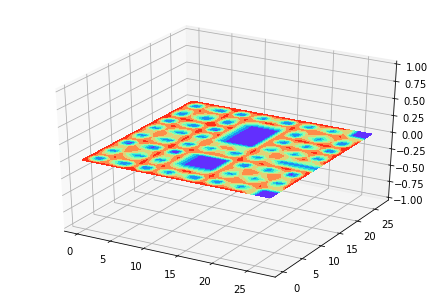

In [182]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()

#fig=plt.subplots[1][1]

ax=Axes3D(fig)

X=np.arange(0,28,1)
Y=np.arange(0,28,1)
X,Y=np.meshgrid(X,Y)

Z=train[1][8] 

#rstride、csride分别为两个方向上的跨度，跨度越大越宽松，越小越密集；cmap设置为彩虹样式
#ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.get_cmap('rainbow'))#彩虹
#ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.get_cmap('Greys'))#Grey

#等高线图contour---细线；contourf---连在一起的宽线条 ；zdir设置从哪个坐标轴压下去;  offset=n,表示等高线图的位置在n
#ax.contourf(X,Y,Z,zdir='z',offset=0,cmap='Greys')
ax.contourf(X,Y,Z,zdir='z',offset=0,cmap='rainbow')

ax.set_zlim(-1,1)

plt.show()

# Problem 3
Another check: We expected the data to be balanced across classes. Verify that.

Merge and prune the data as needed. Depending on your computer setup, you may not be able to fit all in the memory, and you can tune train_size as needed. The labels will be stored into a seperate array of integers 0 through 9.
Also create a validation dataset for hyperpaarmeter tuning.

In [157]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype = np.float32)
        labels = np.ndarray(nb_rows, dtype = np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
                
                
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have randow training and validation set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v: end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter =letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :,:] = train_letter
                train_labels[start_t:end_t] =label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':',e)
            raise
        return valid_dataset, valid_labels,train_dataset, train_labels
    
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels,train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size) 
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll ranmomize data. It's important to have the lables well shuffled for the training and test distributions to match.

In [169]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_datatset = dataset[permutation, :,:]
    shuffled_labels = labels[permutation]
    return shuffled_datatset,shuffled_labels


train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

# Problem 4
Convince yourself the data if good after shuffling!

Finally, let's save the data for later reuse.

In [171]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file,'wb')
    save = {
        'train_datset':train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to ', pickle_file, ':',e)
    raise


In [181]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800505


# Problem 5
 By construction, this dataset may contain a lot of overlapping samples, including train data that's also contained in test and valid data! Overlap between training and test can skew the result if you expect to use your model in an environment where there is never a overlap, but are actully ok if you expect to see training samples recue when you use it. Measure how much overlap there is between test, train and validation samples.
 
 Option questions:
+ what about duplicates between datasets?(images that are almost identical)
- Create a santinized validation and test set, and compare accuracy on those in subsequent assignments.
 

In [194]:
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    
    start = time.perf_counter()
    
    hash1 = set([hash(image1.data) for image1 in images1])
    hash2 = set([hash(image2.data) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.perf_counter()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
#print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

ValueError: memoryview: hashing is restricted to formats 'B', 'b' or 'c'

In [188]:
type(train_dataset)

numpy.ndarray

In [202]:
x = object()

print(hash(x))

print(id(x))

print(id(x)/hash(x))

125499223137
2007987570192
16.0


# Problem 6
Let's get a idea of what a off-the-shelf classfier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trival that a canned solution solves it  

Train a simple data on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use Logistic Regression from sklearn_model

Optional questions: train a off-the-shelf model on all the data.

In [203]:
# Here you have 200000 samples
# 28 x 28 features
# We have to reshape them because scikit-learn expects (n_samples, n_features)
train_dataset.shape

(200000, 28, 28)

In [205]:
test_dataset.shape

(10000, 28, 28)

In [207]:
# Prepare training data
samples, width, height = train_dataset.shape
X_train = np.reshape(train_dataset,(samples,width*height))
y_train = train_labels

# Prepare testing data
samples, width, height = test_dataset.shape
X_test = np.reshape(test_dataset,(samples,width*height))
y_test = test_labels

In [212]:
X_test.shape

(10000, 784)

In [214]:
X_train.shape

(200000, 784)

In [222]:
# Import
from sklearn.linear_model import LogisticRegression

# Instantiate
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

# Fit
lg.fit(X_train, y_train)

# Predict
y_pred = lg.predict(X_test)

# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0